In [56]:
%pip install ipywidgets -q
%pip install --upgrade ipywidgets -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [57]:
import os
import json
from io import StringIO
import numpy as np
import geopandas as gpd
import rasterio

from geodata_fetch.harvest import DataHarvester
from gis_utils.dataframe import get_bbox_from_geodf

from rasterio.plot import show
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, interact

In [58]:
def plot_geotiff(filename):
    file_path = os.path.join(output_dir, filename)
    with rasterio.open(file_path) as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, title=filename)
        plt.show()

#### Setup import and export directories, bring in geometry for aoi

In [59]:
#links to input and output directories
input_dir = "/workspace/notebooks/sandbox/data/stratification"
test_areas_dir = os.path.join(input_dir, "test-areas")

output_dir = "/workspace/notebooks/sandbox/data/stratification/input-rasters"

In [60]:
geojson = {
    'body': {
        "type": "FeatureCollection",
        "name": "dissolved-boundaries",
        "crs": {
            "type": "name",
            "properties": {
                "name": "urn:ogc:def:crs:OGC:1.3:CRS84" 
            }
        },
        "features": [
            {
                "type": "Feature",
                "properties": {
                    "fid": 1
                },
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        [
                            [116.26012130269045, -29.225295369642396],
                            [116.261724812149055, -29.241374854584375],
                            [116.283751968396274, -29.256813692452539],
                            [116.284342735038919, -29.268250184258388],
                            [116.292247755352392, -29.265992437426529],
                            [116.292360282331941, -29.293057573630019],
                            [116.314865678242256, -29.293523728033122],
                            [116.326259034921833, -29.293033039128805],
                            [116.326315298411629, -29.305397680579894],
                            [116.355065941687045, -29.307016748931797],
                            [116.355065941687045, -29.306575187382712],
                            [116.383366477044206, -29.307384715430175],
                            [116.384322956370426, -29.290407813444993],
                            [116.387586238777402, -29.282629879611861],
                            [116.386517232471661, -29.259807919053017],
                            [116.359201308185533, -29.259488866292969],
                            [116.359229439930417, -29.259243440415627],
                            [116.35242155766754, -29.259292525638209],
                            [116.352140240218716, -29.220237788279107],
                            [116.302234524787593, -29.223503148505326],
                            [116.281388901825679, -29.2239696200396],
                            [116.26012130269045, -29.225295369642396]
                        ]
                    ]
                }
            }
        ]
    }
}

bbox: [116.26012130269045, -29.307384715430175, 116.3875862387774, -29.220237788279107]


/tmp/ipykernel_7397/3462533652.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
/tmp/ipykernel_7397/3462533652.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_lat = gdf.centroid.y[0]


<Axes: >

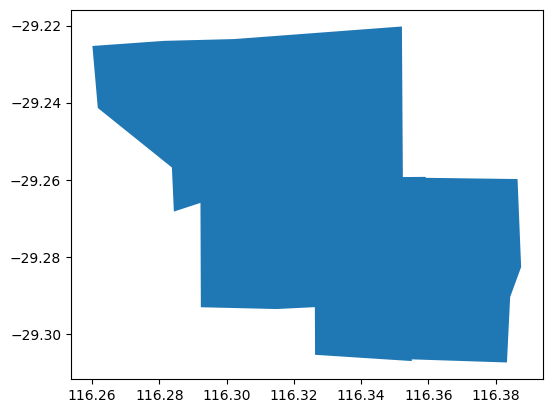

In [61]:
# import geometry for area of interest

req = geojson
geojson_data = req['body']  # Directly accessing the 'body' since it's already a dictionary in this mock setup

# Convert the GeoJSON string to a GeoDataFrame
gdf = gpd.read_file(StringIO(json.dumps(geojson_data)))

geom = gdf.geometry #for data-harvester clip function

bbox = get_bbox_from_geodf(geojson_data)
gdf_lon = gdf.centroid.x[0] #approximate centre latitude based on the input geojson - point roughly in the middle
gdf_lat = gdf.centroid.y[0]

print(f"bbox: {bbox}")

gdf.plot()

#### Set up the json object to be sent to the data harvester

A couple of variations on input data to collect:

In [62]:
# target_sources = {
#     "DEM": "DEM",
#     "SLGA": {
#         "Organic_Carbon": ["0-5cm"]
#     }
# }

# target_sources = {
#     "SLGA": {
#         "Organic_Carbon": ["0-5cm"]
#     }
# }

target_sources = {
    "SLGA": {
        "Organic_Carbon": ["0-5cm"],
        "Clay": ["0-5cm"]
    }
}

In [63]:
propertyName = "stardew_valley"


data_mask=False #we want the full geotiffs so making the datacube is easier
add_buffer = False
resample=False #we will handle resampling in the pre-processing notebook to maintain consistency.

# Resolution of data download in arcseconds (1 arcsec ~ 30m)
target_res = 1
target_proj = "EPSG:4326" # We will reproject to 3857 later on. This will be more accurate for data collection and pre-processing steps.

date_start = "2022-10-01" #these aren't needed for SLGA but are expected in the package and throw error if excluded - need to fix
date_end = "2022-11-30"
time_intervals = 0 #same issue as above, need to fix in geodata package to be optional.

In [64]:

json_data = {
    "property_name":propertyName,
    "outpath": output_dir,
    "data_mask": data_mask,
    "target_res": str(target_res),
    "target_crs": target_proj,
    "date_start": date_start if date_start is not None else "2022-10-01", #a date of some kind must be provided or the harvester complains
    "date_end": date_end if date_end is not None else "2022-11-30",
    "target_centroid_lat": gdf_lat,
    "target_centroid_lng": gdf_lon,
    "time_intervals": time_intervals,
    "target_sources": target_sources,
    "target_bbox": bbox,
    "add_buffer": add_buffer,
    "resample": resample
}

#do this to check for any inputs that can't be serialised to json
for key, value in json_data.items():
    if isinstance(value, np.ndarray):
        print(f"Key '{key}' contains an ndarray.")


In [65]:
data = json.dumps(json_data)

# Create a file-like object from JSON string
json_file_like = StringIO(data)

In [66]:
print(data)

{"property_name": "stardew_valley", "outpath": "/workspace/notebooks/sandbox/data/stratification/input-rasters", "data_mask": false, "target_res": "1", "target_crs": "EPSG:4326", "date_start": "2022-10-01", "date_end": "2022-11-30", "target_centroid_lat": -29.263026061552612, "target_centroid_lng": 116.32813629361138, "time_intervals": 0, "target_sources": {"SLGA": {"Organic_Carbon": ["0-5cm"], "Clay": ["0-5cm"]}}, "target_bbox": [116.26012130269045, -29.307384715430175, 116.3875862387774, -29.220237788279107], "add_buffer": false, "resample": false}


In [67]:
harvester = DataHarvester(json_file_like, geom)
harvester.run()

Requested the following 1 sources: ['SLGA']
WCS data downloaded and saved as SLGA_Organic_Carbon_0-5cm_stardew_valley.tiff
WCS data downloaded and saved as SLGA_Clay_0-5cm_stardew_valley.tiff
SLGA data downloaded successfully: ['SLGA_Organic_Carbon_0-5cm_stardew_valley', 'SLGA_Clay_0-5cm_stardew_valley']


#### Check the data 

In [68]:
# check projection and other data about the geotiffs:

geotiffs = [file for file in os.listdir(output_dir) if file.endswith('.tiff')]

# Dictionary to store data
# Dictionaries to store data, subdivided into 'masked' and 'other'
geotiff_data = {'downloaded': {}, 'masked': {}}

for filename in geotiffs:
    file_path = os.path.join(output_dir, filename)
    with rasterio.open(file_path) as src:
        # Get the CRS, NoData value, and data type
        crs = src.crs
        nodata_value = src.nodata
        resolution = src.res
        num_bands = src.count
        data_types = src.dtypes[0]
        
        # Initialize variables to find min and max values
        min_value, max_value = float('inf'), float('-inf')
        
        # Check all bands for data ranges and missing data
        for i in range(1, src.count + 1):
            band = src.read(i, masked=True)  # Read with mask applied
            min_band_value = np.min(band).item()  # Convert to native Python float
            max_band_value = np.max(band).item()  # Convert to native Python float
            
            # Update the min and max values found
            if min_band_value is not None:
                min_value = min(min_value, min_band_value)
            if max_band_value is not None:
                max_value = max(max_value, max_band_value)
        
        # Determine the group based on filename suffix
        group = 'masked' if filename.endswith('_masked.tiff') else 'downloaded'

        # Store results in the appropriate sub-dictionary
        geotiff_data[group][filename] = {
            'CRS': str(crs),
            'Number of Bands': num_bands,
            'Data Type': data_types,
            'NoData Value': nodata_value,
            'Resolution': resolution,
            'Min Data Value': min_value if min_value != float('inf') else None,
            'Max Data Value': max_value if max_value != float('-inf') else None
        }

# Save results to a JSON file
json_path = os.path.join(output_dir, 'geotiff_data.json')
with open(json_path, 'w') as json_file:
    json.dump(geotiff_data, json_file, indent=4)

print(f"GeoTIFF data saved to {json_path}")

GeoTIFF data saved to /workspace/notebooks/sandbox/data/stratification/input-rasters/geotiff_data.json


In [69]:
# Create a dropdown to select a GeoTIFF file
dropdown = Dropdown(options=geotiffs)

# Use interact to create a UI element for file selection
interact(plot_geotiff, filename=dropdown)

interactive(children=(Dropdown(description='filename', options=('SLGA_Organic_Carbon_0-5cm_stardew_valley.tiff…

<function __main__.plot_geotiff(filename)>